## 实验二：基于卷积神经网络的MNIST手写体数字识别

### 准备工作

我们使用Pytorch框架，导入所需要的包，并读入数据。然后，我们对数据进行一些预处理，并生成训练和测试的数据集，详见代码。

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

### 定义网络模型

在这里定义 ResNet 最重要的两种模块： BasicBlock 和 BottleneckBlock。两者都有前者是一个两个 (3x3, 64) 卷积核相继，后者是 (1x1, 64), (3x3, 64), (1x1, 256) 的卷积核相继；为了改善梯度消失的问题，两者都采用了残差学习，即把输入（残差）和卷积层最后的输出相加。由于 BottleneckBlock 的输入大小是 256，我们还需要一个 downsample 层，让残差的大小与卷积层的输出匹配。

构建好这两种模块之后，我们以此来构建 ResNet。

In [7]:
import torch.nn as nn

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class BottleneckBlock(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BottleneckBlock, self).__init__()
        width = int(out_channels * (64 / 64.0)) * 1
        self.conv1 = nn.Conv2d(in_channels, width, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = nn.Conv2d(width, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out) 
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out) 
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers):
        super(ResNet, self).__init__()
        self.in_channels = 64
        # BasicBlock
        # self.conv = nn.Conv2d(1, self.in_channels, kernel_size=7, stride=2, padding=3)
        # BottleneckBlock
        self.conv = nn.Conv2d(1, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], 2)
        self.layer3 = self._make_layer(block, 256, layers[2], 2)
        self.layer4 = self._make_layer(block, 512, layers[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, 10)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels * block.expansion)
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    

### 对不同配置参数的模型进行训练和评估

采用控制变量法的方式，在给出一个基准配置之后逐项改变模型配置，对每一个配置都训练相应模型，并观察配置的改变对模型的损失和准确率有何影响。

这里采用的基准配置是：学习率 0.01，网络架构是 ResNet18。训练 epoch 设为 30。

In [8]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

baseline_config = {
    'lr': 0.01,
    'arch': {
        'name': "ResNet18",
        'block': BasicBlock,
        'layers': [2, 2, 2, 2]
    }
}

configs_to_explore = {
    'lr': [0.001, 0.01, 0.1],
    'arch': [
        {
            'name': "ResNet18",
            'block': BasicBlock,
            'layers': [2, 2, 2, 2]
        },
        {
            'name': "ResNet34",
            'block': BasicBlock,
            'layers': [3, 4, 6, 3]
        },
        {
            'name': "ResNet50",
            'block': BottleneckBlock,
            'layers': [3, 4, 6, 3]
        }
    ]
}

results = {
    'lr': {},
    'arch': {}
}


for variable, values in configs_to_explore.items():
    for value in values:
        config = baseline_config.copy()
        config[variable] = value
        print('Evaluating', variable, value)
        model = ResNet(config['arch']['block'], config['arch']['layers']).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=config['lr'])

        train_losses, test_losses, test_accuracies = [], [], []

        for epoch in range(30):  
            model.train()
            running_loss = 0.0
            for i, data in enumerate(trainloader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            running_loss /= len(trainloader)
            train_losses.append(running_loss)

            print(f'Epoch {epoch + 1}, Loss: {running_loss}')

            model.eval()
            correct = 0
            total = 0
            test_loss = 0.0
            with torch.no_grad():
                for data in testloader:
                    images, labels = data
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    test_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                test_loss /= len(testloader)
                test_losses.append(test_loss)
                test_accuracies.append(correct / total)

            print(f'Accuracy of the network on the test images: {100 * correct / total} %')
        

        torch.save(model.state_dict(),
                   'models/model_{}_{}.pth'.format(variable, value))
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))

        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                # print(outputs.shape)
                _, predicted = torch.max(outputs, 1)
                c = (predicted == labels).squeeze()
                for i in range(len(labels)):
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1

        for i in range(10):
            print(f'Accuracy of {i} : {100 * class_correct[i] / class_total[i]} %')
        results[variable][value['name']
                          if type(value) is dict
                          else value] = (train_losses,
                                    test_losses,
                                    test_accuracies,
                                    [100 * class_correct[i] / class_total[i]
                                     for i in range(10)])

cuda
Evaluating lr 0.001
Epoch 1, Loss: 0.13353961112046206
Accuracy of the network on the test images: 96.51 %
Epoch 2, Loss: 0.06434803197881692
Accuracy of the network on the test images: 98.43 %
Epoch 3, Loss: 0.046830874054753745
Accuracy of the network on the test images: 98.27 %
Epoch 4, Loss: 0.040391490052477504
Accuracy of the network on the test images: 98.97 %
Epoch 5, Loss: 0.03352545001675615
Accuracy of the network on the test images: 99.19 %
Epoch 6, Loss: 0.03006639773445477
Accuracy of the network on the test images: 98.64 %
Epoch 7, Loss: 0.026849147719951016
Accuracy of the network on the test images: 98.95 %
Epoch 8, Loss: 0.02177890301474791
Accuracy of the network on the test images: 98.79 %
Epoch 9, Loss: 0.023157999926315086
Accuracy of the network on the test images: 98.84 %
Epoch 10, Loss: 0.018837578851418083
Accuracy of the network on the test images: 99.01 %
Epoch 11, Loss: 0.017505014832391266
Accuracy of the network on the test images: 99.08 %
Epoch 12, 

### 可视化

按照控制变量的方式，把只改变某一项的所有模型 loss 和 accuracy 一同画在一张图中。

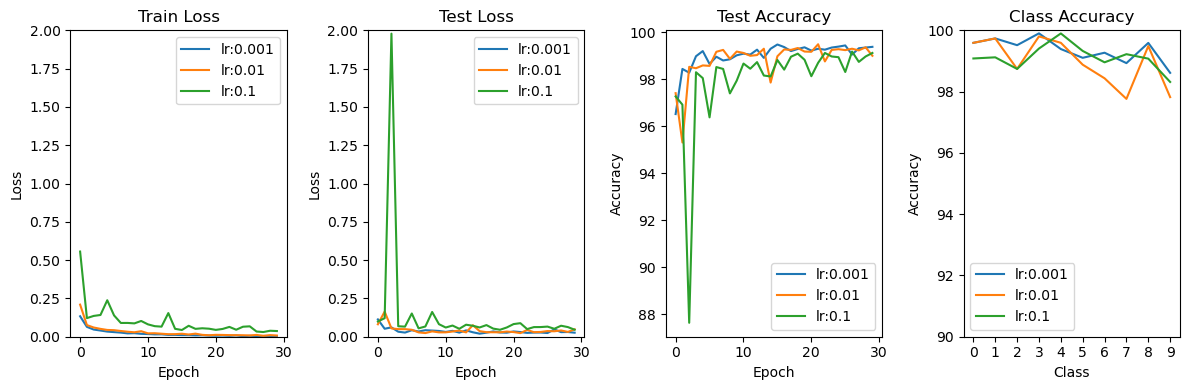

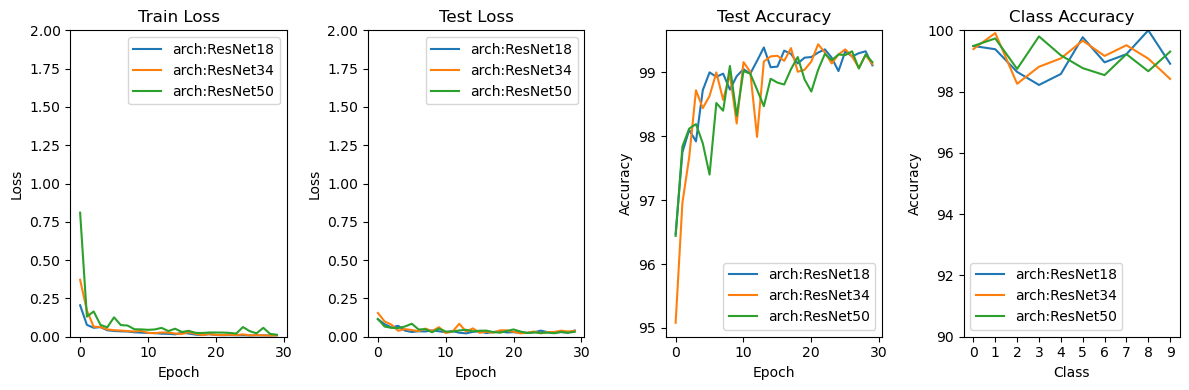

In [17]:
import matplotlib.pyplot as plt

for variable, configs in results.items():
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 4, 1)
    for value, (train_losses, _, _, _) in configs.items():
        plt.plot(train_losses, label=f'{variable}:{value}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim(0, 2)
    plt.title('Train Loss')
    plt.legend()

    plt.subplot(1, 4, 2)
    for value, (_, test_losses, _, _) in configs.items():
        plt.plot(test_losses, label=f'{variable}:{value}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim(0, 2)
    plt.title('Test Loss')
    plt.legend()

    plt.subplot(1, 4, 3)
    for value, (_, _, test_accuracies, _) in configs.items():
        test_accuracies = [100 * acc for acc in test_accuracies]
        plt.plot(test_accuracies, label=f'{variable}:{value}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy')
    plt.legend()

    plt.subplot(1, 4, 4)
    for value, (_, _, _, class_accuracies) in configs.items():
        plt.plot(class_accuracies, label=f'{variable}:{value}')
    plt.xlabel('Class')
    plt.xticks(range(10))
    plt.ylabel('Accuracy')
    plt.ylim(90, 100)
    plt.title('Class Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


### 结果分析

总体来看，各配置下神经网络对于该数据集都能很快收敛，而后 loss 和 accuracy 稳定在一个水平，这可能是因为各个模型对于该任务来说都比较大。

##### 学习率

```
Evaluating lr 0.1
Final Train Accuracy: 0.9192
Final Test Accuracy: 0.9225

Evaluating lr 0.01
Final Train Accuracy: 0.9225
Final Test Accuracy: 0.9375

Evaluating lr 0.001
Final Train Accuracy: 0.9283
Final Test Accuracy: 0.9375
```

本次实验采用了 0.1、0.01 和 0.001三种学习率，观察上图我们可以发现 0.1 学习率下，模型的 loss 和 accuracy 均有较大波动，收敛也较慢，而另外两种都较为稳定。

##### 网络架构

由图可得，ResNet34 的性能与 ResNet18 相近，但是 ResNet50 较前两者不容易收敛。准确度上，三个模型的准确度对于每一类别均能达到 98% 以上。

